In [6]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import scipy

mid = 288 # K
half_range = 20 # K
step = 5 # K
zt0_range = np.arange(mid-half_range, mid+half_range+step, step)
ne = len(zt0_range)
nt = 10
var = "zt0"
ensemble_colors = plt.cm.viridis(np.linspace(0, 1, ne))
ds_in_path = Path(f"/glade/work/jmelms/data/dcmip2025_idealized_tests/initial_conditions/steady-state/output/nt={nt}_ne={len(zt0_range)}_var={var}.nc")
print(f"Data exists @ {ds_in_path}\nStatus: {ds_in_path.exists()}")

Data exists @ /glade/work/jmelms/data/dcmip2025_idealized_tests/initial_conditions/steady-state/output/nt=10_ne=9_var=zt0.nc
Status: True


In [7]:
ds = xr.open_dataset(ds_in_path)
variables = list(ds.keys())
ds

<xarray.Dataset> Size: 30GB
Dimensions:    (time: 11, ensemble: 9, latitude: 721, longitude: 1440, level: 13)
Coordinates:
  * time       (time) datetime64[ns] 88B 1850-01-01 ... 1850-01-03T12:00:00
  * level      (level) int64 104B 50 100 150 200 250 ... 600 700 850 925 1000
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 12kB 0.0 0.2502 0.5003 ... 359.5 359.7 360.0
  * ensemble   (ensemble) int64 72B 268 273 278 283 288 293 298 303 308
Data variables: (12/13)
    VAR_10U    (time, ensemble, latitude, longitude) float32 411MB ...
    VAR_10V    (time, ensemble, latitude, longitude) float32 411MB ...
    VAR_100U   (time, ensemble, latitude, longitude) float32 411MB ...
    VAR_100V   (time, ensemble, latitude, longitude) float32 411MB ...
    VAR_2T     (time, ensemble, latitude, longitude) float32 411MB ...
    SP         (time, ensemble, latitude, longitude) float32 411MB ...
    ...         ...
    TCW        (time, ensemble, latitude, longitude) float32 411MB ...
    U          (time, ensemble, level, latitude, longitude) float32 5GB ...
    V          (time, ensemble, level, latitude, longitude) float32 5GB ...
    Z          (time, ensemble, level, latitude, longitude) float32 5GB ...
    T          (time, ensemble, level, latitude, longitude) float32 5GB ...
    R          (time, ensemble, level, latitude, longitude) float32 5GB ...

### Plot vertical profile of T, z, u/v at a point

In [11]:
# bloomington, IN at 39.5N, 86.5W and denver, CO at 39.5N, 105W
plot_vars = ["T"]
# Convert latitude to radians for weighting
lat_radians = np.deg2rad(ds.latitude)

# Compute latitude weights using cosine weighting
weights = np.cos(lat_radians)

# Normalize weights to sum to 1 over latitude
weights /= weights.sum()

# Apply latitude weighting and take the global mean over lat/lon
atmos_mean_t = (ds["T"] * weights).sum(dim="latitude").mean(dim="longitude")
var = plot_vars[0]
plevs = ds.level.values
lat, lon = (39.5, 360-105.)
point_ds = ds.sel(latitude=lat, longitude=lon, method="nearest")
# fig, ax = plt.subplots()
for t in range(nt):
    fig, ax = plt.subplots(figsize=(6, 8))
    for e in range(ne):
        # dat = point_ds.isel(time=t, ensemble=e)
        dat = atmos_mean_t.isel(time=t, ensemble=e)
        v_profile = dat.values
        ax.plot(v_profile, plevs, label=f"{var}", marker=".", markeredgecolor="black", color=ensemble_colors[e])
        # sfc_p = dat["SP"].values / 100 # Pa to hPa
        # ax.hlines(sfc_p, xmin=v_profile.min(), xmax=v_profile.max(), color="red", linestyle="--", label="SP")
        ax.set_xlabel(f"{var}")
        ax.set_ylabel("Pressure (hPa)")
        ax.set_yscale("log")
        ax.set_yticks(plevs)
        ax.set_yticklabels(plevs)
        ax.set_ylim(plevs[-1], plevs[0])
    xlims = atmos_mean_t.min(), atmos_mean_t.max()
    ax.set_xlim(*xlims)
    ax.set_title(f"{var} @ t={t*6} hrs, pos=({lat}N,{lon}W)")
    fig.savefig(f"/glade/u/home/jmelms/projects/dcmip2025_idealized_tests/analysis/plots/{var}_profile_t{t*6}.png")
    plt.close(fig)

In [12]:
atmos_mean_t.min(), atmos_mean_t.max()

(<xarray.DataArray ()> Size: 8B
 array(172.53609898),
 <xarray.DataArray ()> Size: 8B
 array(302.89513265))

### Plot Lat-Weighted Global Mean Surface Temperature

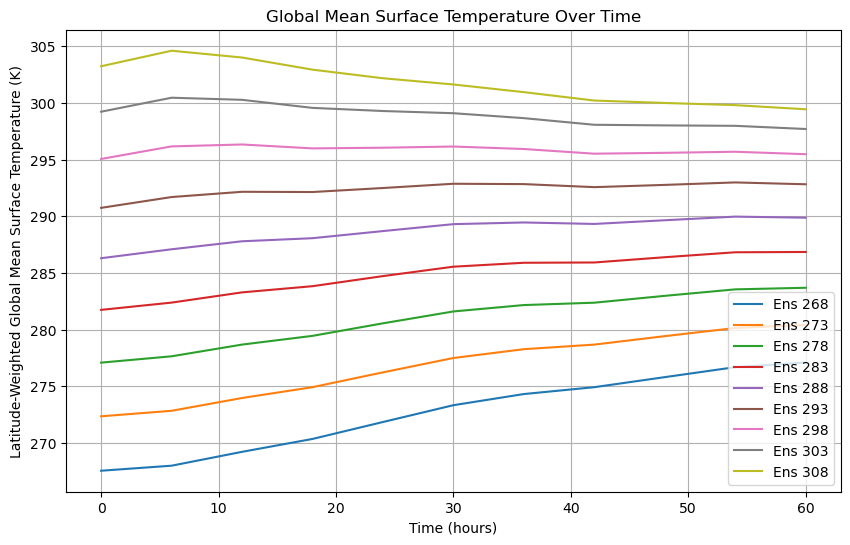

In [4]:
# Extract surface temperature variable
surface_temp = ds['VAR_2T']  # Shape: (time, ensemble, latitude, longitude)

# Convert latitude to radians for weighting
lat_radians = np.deg2rad(ds.latitude)

# Compute latitude weights using cosine weighting
weights = np.cos(lat_radians)

# Normalize weights to sum to 1 over latitude
weights /= weights.sum()

# Apply latitude weighting and take the global mean over lat/lon
global_mean_t = (surface_temp * weights).sum(dim="latitude").mean(dim="longitude")

# Now `global_mean_t` has shape (time, ensemble)
# Convert time to timedelta (hours since first time step)
time_hours = (ds.time - ds.time[0]) / np.timedelta64(1, "h")

# Plot the results
plt.figure(figsize=(10, 6))

for ens in ds.ensemble:
    plt.plot(time_hours, global_mean_t.sel(ensemble=ens.item()), label=f'Ens {ens.item()}')

plt.xlabel("Time (hours)")
plt.ylabel("Latitude-Weighted Global Mean Surface Temperature (K)")
plt.title("Global Mean Surface Temperature Over Time")
plt.legend()
plt.grid()
plt.show()


### Plot Lat-Weighted Global Mean Column Total Energy

In [15]:
# the below section will eventually matter, but it's not necessary for now due to high pressure at the surface
### define integration bounds at each point using station pressure ###
# integrable_ds = ds.copy()
# sp = integrable_ds["SP"].values / 100 # Pa to hPa
# # for vars w/ dim (..., level, ...), set values where level > sp to nan
# for var in integrable_ds.keys():
#     if "level" in integrable_ds[var].dims:
#         for level in integrable_ds.level.values:
#             integrable_ds[var].loc[dict(level=level)] = np.where(np.full_like(integrable_ds[var].sel(level=level).values, level) > sp, np.nan, integrable_ds[var].sel(level=level).values)

# get pressure
pa = ds.level.values

# define consts
cp = 1005.0 # J/kg/K
g = 9.81 # m/s^2
Lv = 2.26e6 # J/kg

### Calc pointwise total energy ###

# sensible heat
sensible_heat = cp*ds["T"]
# latent heat - this is already column-integrated
latent_heat = Lv*ds["TCW"]
# geopotential energy
geopotential_energy = g*ds["Z"]
# kinetic energy
kinetic_energy = 0.5*ds["U"]**2 + 0.5*ds["V"]**2

# total energy minus latent heat
dry_total_energy = sensible_heat + geopotential_energy + kinetic_energy
# column integration
dry_total_energy_column = (1/g) * scipy.integrate.trapezoid(dry_total_energy, pa, axis=2)
# sum
total_energy = dry_total_energy_column + latent_heat
total_energy

<xarray.DataArray 'TCW' (time: 11, ensemble: 9, latitude: 721, longitude: 1440)> Size: 411MB
array([[[[7.57392720e+07, 7.57392720e+07, 7.57392720e+07, ...,
          7.57392720e+07, 7.57392720e+07, 7.57392720e+07],
         [7.57392720e+07, 7.57392720e+07, 7.57392720e+07, ...,
          7.57392720e+07, 7.57392720e+07, 7.57392720e+07],
         [7.57392720e+07, 7.57392720e+07, 7.57392720e+07, ...,
          7.57392720e+07, 7.57392720e+07, 7.57392720e+07],
         ...,
         [7.57392720e+07, 7.57392720e+07, 7.57392720e+07, ...,
          7.57392720e+07, 7.57392720e+07, 7.57392720e+07],
         [7.57392720e+07, 7.57392720e+07, 7.57392720e+07, ...,
          7.57392720e+07, 7.57392720e+07, 7.57392720e+07],
         [7.57392720e+07, 7.57392720e+07, 7.57392720e+07, ...,
          7.57392720e+07, 7.57392720e+07, 7.57392720e+07]],

        [[7.80176400e+07, 7.80176400e+07, 7.80176400e+07, ...,
          7.80176400e+07, 7.80176400e+07, 7.80176400e+07],
         [7.80176400e+07, 7.80176400e+07, 7.80176400e+07, ...,
          7.80176400e+07, 7.80176400e+07, 7.80176400e+07],
         [7.80176400e+07, 7.80176400e+07, 7.80176400e+07, ...,
          7.80176400e+07, 7.80176400e+07, 7.80176400e+07],
...
          1.14233904e+08, 1.14236624e+08, 1.14239264e+08],
         [1.14046816e+08, 1.14047984e+08, 1.14049104e+08, ...,
          1.14043232e+08, 1.14044432e+08, 1.14045672e+08],
         [1.13077344e+08, 1.13077344e+08, 1.13077344e+08, ...,
          1.13077344e+08, 1.13077344e+08, 1.13077344e+08]],

        [[7.54610640e+07, 7.54610640e+07, 7.54610640e+07, ...,
          7.54610640e+07, 7.54610640e+07, 7.54610640e+07],
         [7.82629120e+07, 7.82593440e+07, 7.82558160e+07, ...,
          7.82732480e+07, 7.82698080e+07, 7.82663680e+07],
         [8.41519920e+07, 8.41453440e+07, 8.41387520e+07, ...,
          8.41714720e+07, 8.41650080e+07, 8.41585120e+07],
         ...,
         [1.20304296e+08, 1.20306384e+08, 1.20308456e+08, ...,
          1.20297968e+08, 1.20300136e+08, 1.20302256e+08],
         [1.20386848e+08, 1.20387688e+08, 1.20388584e+08, ...,
          1.20383920e+08, 1.20384912e+08, 1.20385840e+08],
         [1.19720496e+08, 1.19720496e+08, 1.19720496e+08, ...,
          1.19720496e+08, 1.19720496e+08, 1.19720496e+08]]]],
      shape=(11, 9, 721, 1440), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 88B 1850-01-01 ... 1850-01-03T12:00:00
  * latitude   (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 12kB 0.0 0.2502 0.5003 ... 359.5 359.7 360.0
  * ensemble   (ensemble) int64 72B 268 273 278 283 288 293 298 303 308

### Plot Lat-weighted Global Mean Column Energy

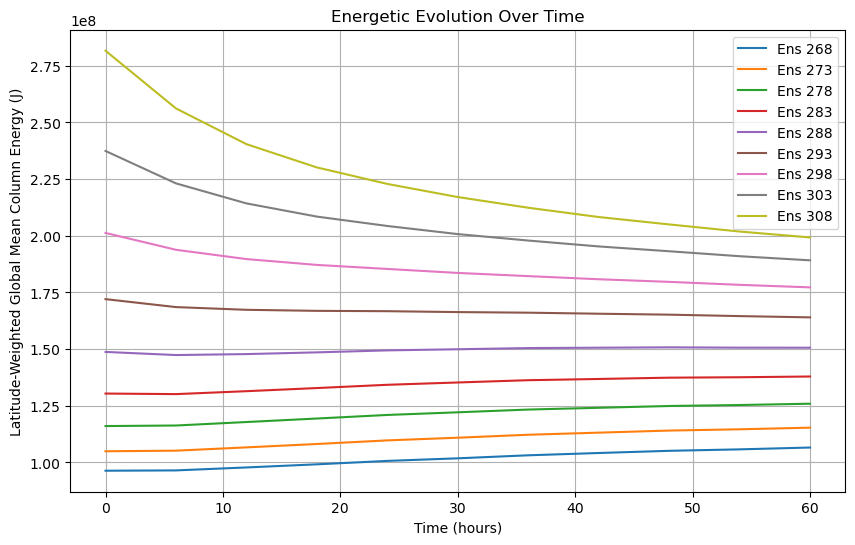

In [16]:
# Extract surface temperature variable
te = total_energy  # Shape: (time, ensemble, latitude, longitude)

# Convert latitude to radians for weighting
lat_radians = np.deg2rad(ds.latitude)

# Compute latitude weights using cosine weighting
weights = np.cos(lat_radians)

# Normalize weights to sum to 1 over latitude
weights /= weights.sum()

# Apply latitude weighting and take the global mean over lat/lon
gm_te = (te * weights).sum(dim="latitude").mean(dim="longitude")

# Now `global_mean_te` has shape (time, ensemble)
# Convert time to timedelta (hours since first time step)
time_hours = (ds.time - ds.time[0]) / np.timedelta64(1, "h")

# Plot the results
plt.figure(figsize=(10, 6))

for ens in ds.ensemble:
    plt.plot(time_hours, gm_te.sel(ensemble=ens.item()), label=f'Ens {ens.item()}')

plt.xlabel("Time (hours)")
plt.ylabel("Latitude-Weighted Global Mean Column Energy (J)")
plt.title("Energetic Evolution Over Time")
plt.legend()
plt.grid()
plt.show()


### Calculate Energetic Input

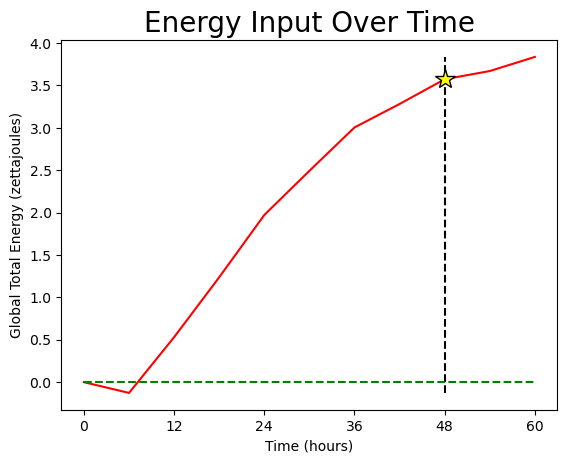

In [45]:
R = 6.371e6 # m
A = 4*np.pi*R**2
ens_mem = 283
global_te = gm_te.sel(ensemble=ens_mem) * A
te_delta = global_te - global_te[0]
ted_ZJ = te_delta / 1e21
dat = ted_ZJ
plt.plot(time_hours, dat, color="red")
plt.xticks(time_hours[::2])
plt.xlabel("Time (hours)")
plt.ylabel("Global Total Energy (zettajoules)")
plt.title("Energy Input Over Time", fontsize=20)
plt.vlines(time_hours[8], dat.min(), dat.max(), color="black", linestyle="--", label="t=48 hrs")
plt.hlines(0, time_hours.min(), time_hours.max(), color="green", linestyle="--")
plt.plot(time_hours[8], dat[8], marker="*", markersize=15, markeredgecolor="k", color="yellow", label="t=24 hrs")
plt.show()

### Calculate Butter Ball Size

In [18]:
e_diff = te_delta[4].item() # energy input (J) after 24 hours
e_diff_kcal = e_diff / 4184 # kcal
kcal_per_kg_butter = 7170 # kcal/kg
butter_mass = e_diff_kcal / kcal_per_kg_butter # kg
butter_density = 960 # kg/m^3
butter_volume = butter_mass / butter_density # m^3
butter_radius = (3*butter_volume / (4*np.pi))**(1/3) # m
butter_side_length = (butter_volume/2)**(1/3) # m
butter_radius, butter_side_length


(2537.8914295392565, 3247.0769219436347)

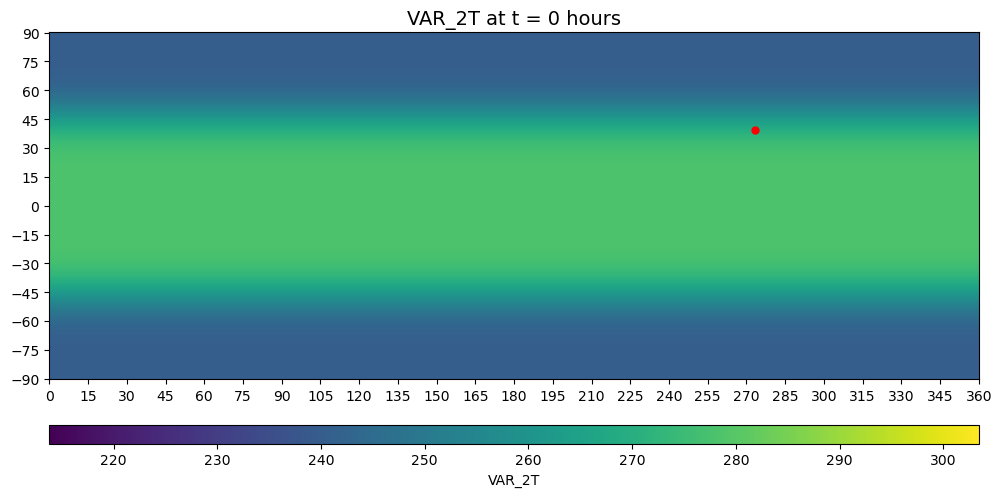

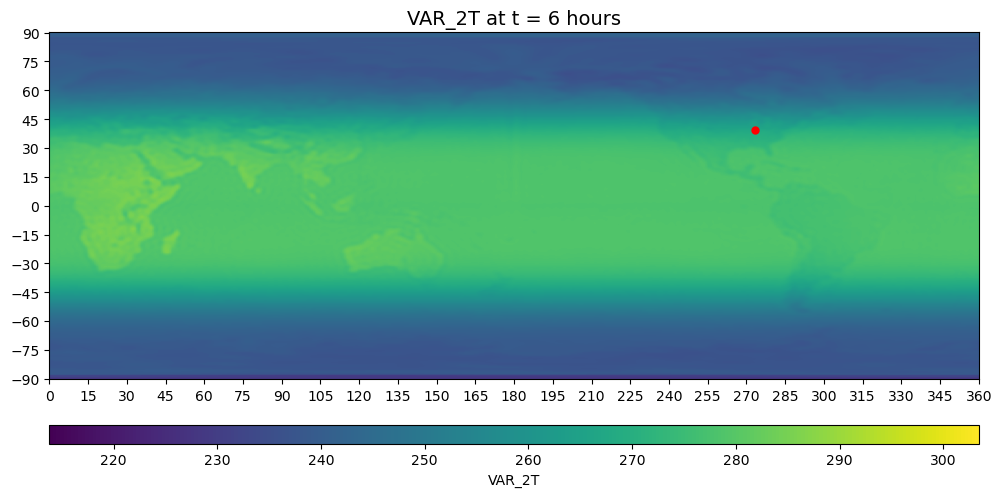

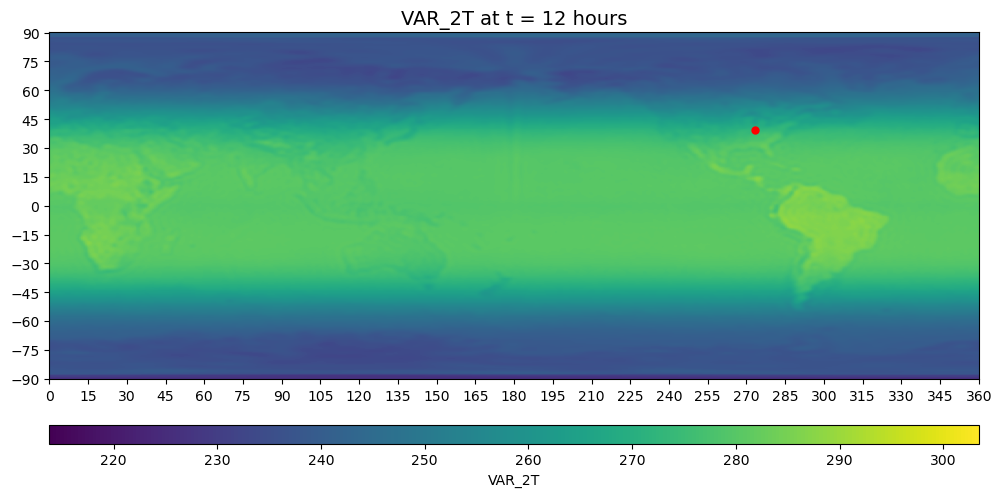

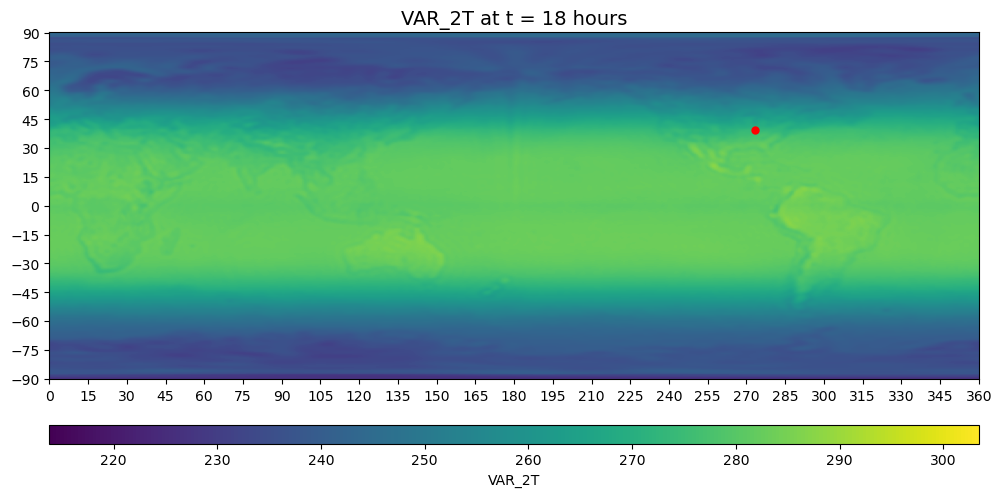

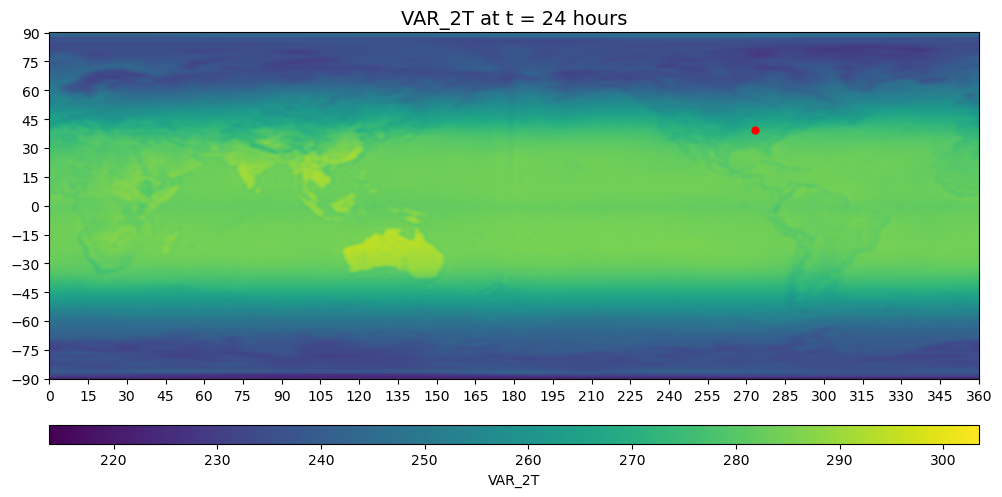

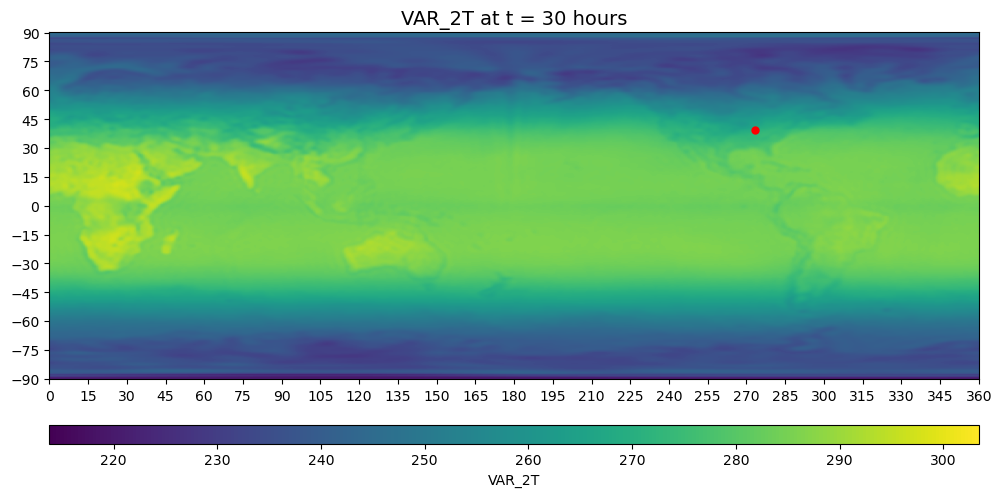

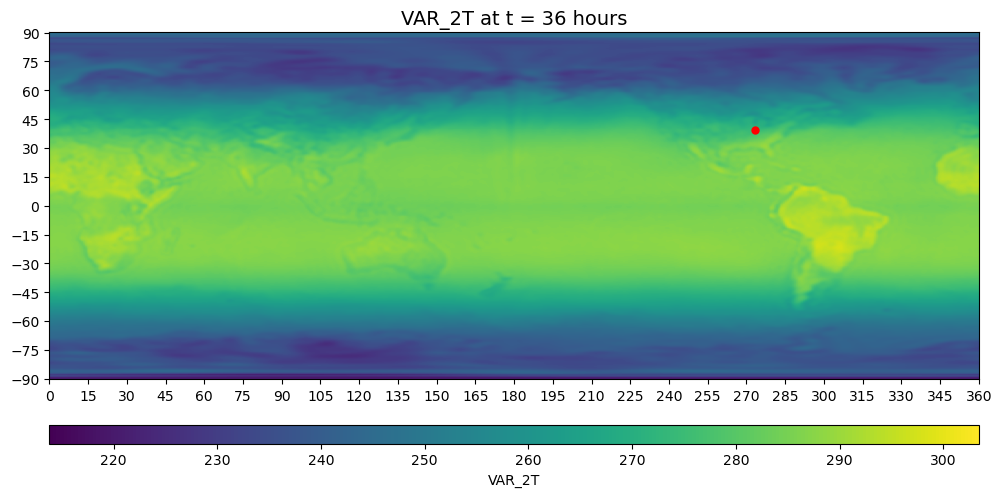

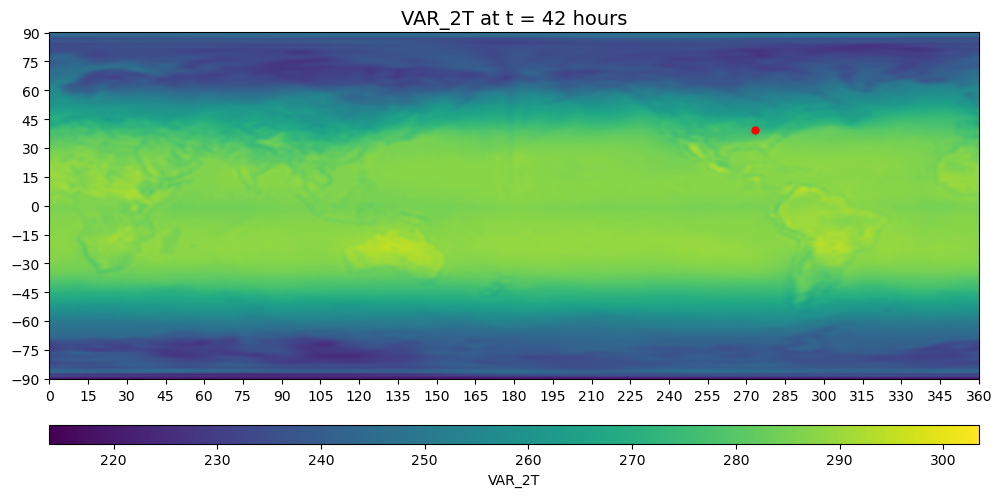

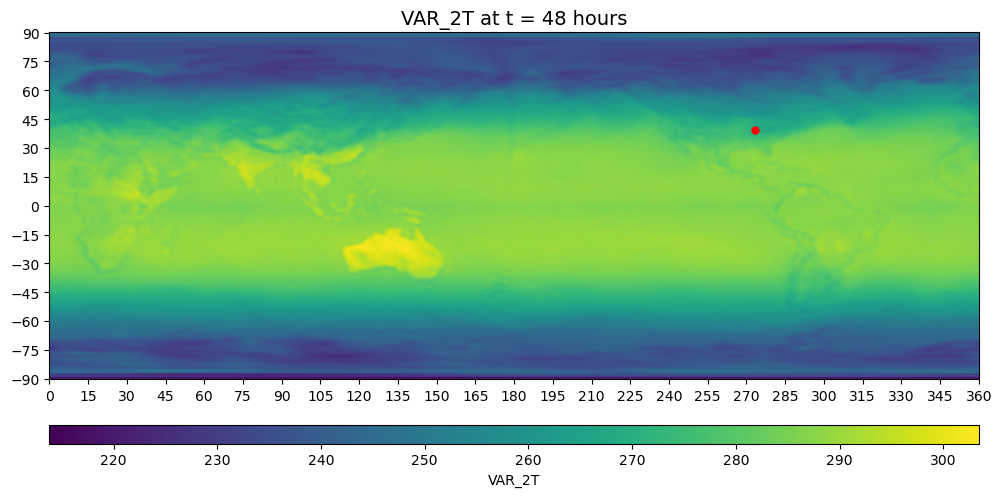

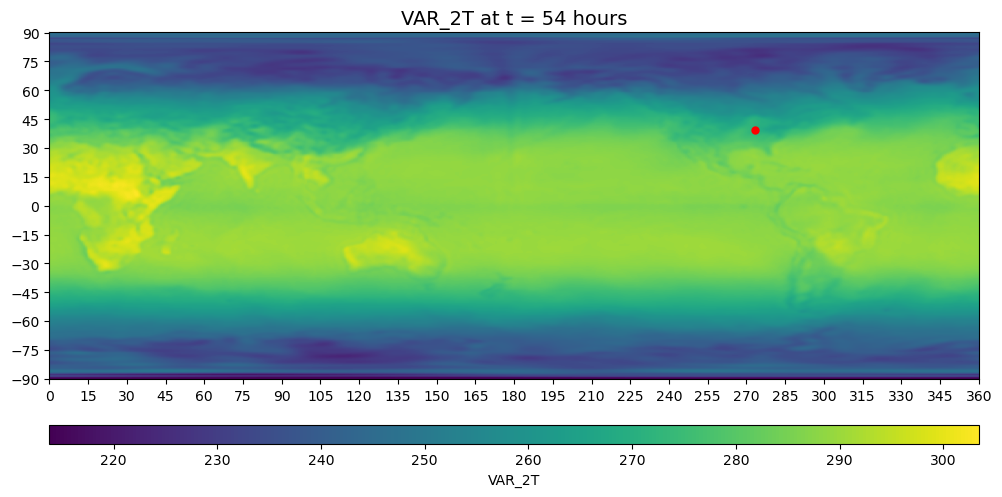

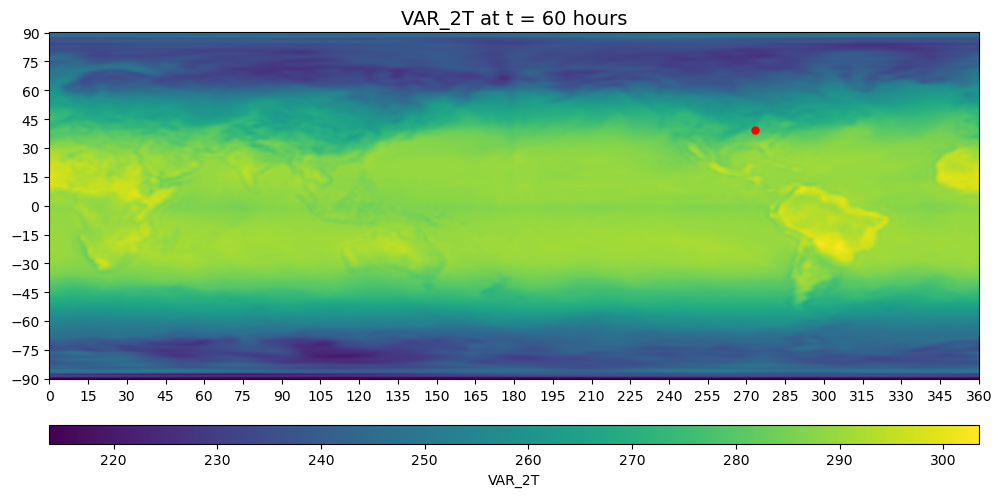

In [29]:
def plot_variable(ds, var_name, levels=None, point=None):
    """
    Plots the given variable from an xarray dataset over multiple timesteps.

    Parameters:
        ds (xarray.Dataset): The dataset containing the variable.
        var_name (str): Name of the variable to plot.
        levels (int or list, optional): Contour levels for the color scale.
        point (tuple, optional): Latitude and longitude of the point to plot.
    """
    # Extract variable and coordinates
    data = ds[var_name].isel(ensemble=0)
    times = ds.time.values
    lats = ds.latitude.values
    lons = ds.longitude.values

    # Convert times to hours since the first timestamp
    time_deltas = (times - times[0]) / np.timedelta64(1, "h")

    # Create lat/lon tick marks every 15 degrees
    lat_ticks = np.arange(-90, 91, 15)
    lon_ticks = np.arange(0, 361, 15)

    # Determine color scale limits (global min/max)
    vmin, vmax = data.min().item(), data.max().item()

    # Create a figure for each time step
    for i, delta_t in enumerate(time_deltas):
        plt.figure(figsize=(12, 6))

        # Plot data as a heatmap
        im = plt.pcolormesh(lons, lats, data.sel(time=times[i]), cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)
        
        # plot point
        if point:
            plt.plot(point[1], point[0], marker="o", color="red", markersize=5)

        # Add colorbar
        cbar = plt.colorbar(im, orientation="horizontal", pad=0.1, aspect=50)
        cbar.set_label(var_name)

        # Configure ticks and labels
        plt.xticks(lon_ticks)
        plt.yticks(lat_ticks)

        # Title with time in hours
        plt.title(f"{var_name} at t = {delta_t:.0f} hours", fontsize=14)

        # Show plot
        plt.show()

# Example usage:
# ds = xr.open_dataset("your_dataset.nc")  # Uncomment if loading from a file
plot_variable(ds, "VAR_2T", point=(39.5, 360-86.5))